In [1]:
import torch
from ppuu.data.dataloader import Dataset, DataStore
from torch.utils.data import DataLoader

import pytorch_lightning as pl

pl.seed_everything(1)

# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/traffic-data_offroad/state-action-cost/data_i80_v0/"
# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/traffic-data_offroad_50_test_train_same/state-action-cost/data_i80_v0/"
ds_path = "/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/"
data_store = DataStore(ds_path)

dataset = Dataset(
    data_store, "train", 20, 30, size=1000, normalize=True, shift=False, random_actions=False,
)
dataset.random.seed(1)

In [2]:
loader = DataLoader(
    dataset,
    batch_size=6,
    num_workers=0,
)

In [3]:
it = iter(loader)

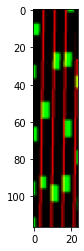

In [5]:
from matplotlib import pyplot as plt

batch = next(it)

plt.imshow(batch['input_images'][0][19].detach().permute(1, 2, 0).numpy())

In [6]:
batch['stats']['s_std']

tensor([[3.9264e+02, 4.4071e+01, 2.5642e-03, 3.5596e-02, 2.4480e+01],
        [3.9264e+02, 4.4071e+01, 2.5642e-03, 3.5596e-02, 2.4480e+01],
        [3.9264e+02, 4.4071e+01, 2.5642e-03, 3.5596e-02, 2.4480e+01],
        [3.9264e+02, 4.4071e+01, 2.5642e-03, 3.5596e-02, 2.4480e+01],
        [3.9264e+02, 4.4071e+01, 2.5642e-03, 3.5596e-02, 2.4480e+01],
        [3.9264e+02, 4.4071e+01, 2.5642e-03, 3.5596e-02, 2.4480e+01]])

In [7]:
batch['actions'][0]

tensor([[-0.4622,  0.0173],
        [-0.1401,  0.0286],
        [ 0.2851,  0.0121],
        [ 0.3941,  0.0090],
        [ 0.2831,  0.0365],
        [ 0.2353, -0.0114],
        [ 0.3341, -0.2521],
        [ 0.4356, -0.3234],
        [ 0.3511, -0.4514],
        [ 0.1782, -0.2066],
        [ 0.1866, -0.1154],
        [ 0.4383, -0.0050],
        [ 0.6536,  0.0415],
        [ 0.9754,  0.0185],
        [ 0.8093,  0.0251],
        [ 0.3708,  0.0162],
        [ 0.0827,  0.0025],
        [-0.4155,  0.0123],
        [-0.7009,  0.0138],
        [-0.6023, -0.0034],
        [-0.2935, -0.0155],
        [-0.0470, -0.0101],
        [-0.1092, -0.0120],
        [-0.3817, -0.0125],
        [-0.4595, -0.0146],
        [-0.3557, -0.0111],
        [-0.2934, -0.0094],
        [-0.5374, -0.0013],
        [-0.8071, -0.0257],
        [-1.2587, -0.0133]])

# New Forward Model

In [8]:
from ppuu.lightning_modules.fm import FM

# fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/refactored_debug/test_no_shift_30_vlong_groupnorm_resume/seed=42_resume_2/checkpoints/epoch=59_success_rate=0.ckpt')
# fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/refactored_debug/test_no_shift_20_vlong_groupnorm_beta=1e-5_continue_correct/seed=42/checkpoints/epoch=2209_success_rate=0.ckpt')
# fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/fm/new_states_30_2/seed=42/checkpoints/epoch=49_success_rate=0.ckpt')
# fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/refactored_debug/new_states_30_2/seed=42/checkpoints/last.ckpt')
fm = FM.load_from_checkpoint('/home/us441/nvidia-collab/vlad/results/fm/km_no_action/fm_km_no_action_64/seed=42/checkpoints/last.ckpt')
# fm.model.enable_latent = True
# fm.model.z_expander.weight

In [10]:
fm._setup_normalizer(data_store.stats)

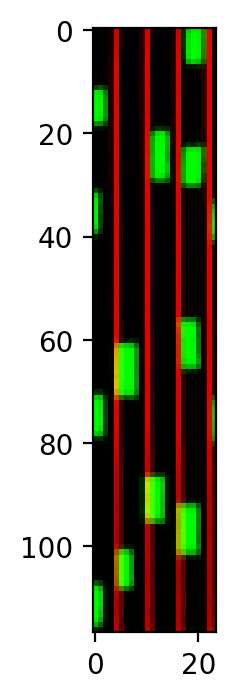

In [46]:
n_actions = batch['actions'].clone()
# n_actions[..., 0] = 5
Z=-5*torch.zeros(*batch['actions'].shape[:2], 32)
predictions = fm.model.unfold(n_actions, batch, Z=Z)
plt.figure(dpi=200)
plt.imshow(predictions['pred_images'][0][29].detach().permute(1, 2, 0).numpy())

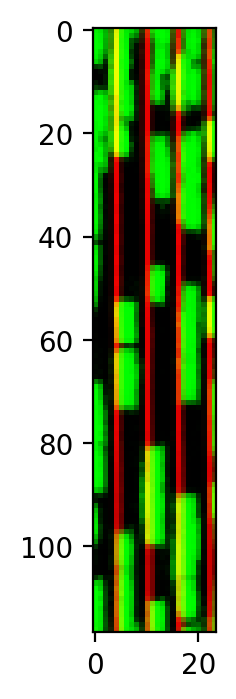

In [47]:
preds = []
for i in range(6):
    Z = torch.randn(*batch['actions'].shape[:2], 32) * 2
    n_actions = batch['actions'].clone()
    predictions = fm.model.unfold(n_actions, batch, Z=Z)
    preds.append(predictions['pred_images'][0][29])
mn_pred = torch.stack(preds).max(dim=0).values
plt.figure(dpi=200)
plt.imshow(mn_pred.detach().permute(1, 2, 0).numpy())

# Old Forward Model

In [53]:
from ppuu.modeling.forward_models import ForwardModel

fm_old = ForwardModel('/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/models/offroad/model=fwd-cnn-vae-fp-layers=3-bsize=64-ncond=20-npred=20-lrt=0.0001-nfeature=256-dropout=0.1-nz=32-beta=1e-06-zdropout=0.5-gclip=5.0-warmstart=1-seed=1.step400000.model')
fm_old.cuda()

def convert_batch(batch):
    res = {}
    for k in batch:
        if k in ['input_images', 'input_states', 'actions', 'ego_cars']:
            res[k] = batch[k].cuda()
    return res
batch_c = convert_batch(batch)

In [54]:
predictions_old = fm_old.unfold(batch_c['actions'], batch_c)

RuntimeError: size mismatch, m1: [1 x 100], m2: [80 x 256] at /opt/conda/conda-bld/pytorch_1587428207430/work/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [ ]:
plt.imshow(predictions_old['pred_images'][0][29].detach().cpu().permute(1, 2, 0).numpy())

# Costs

In [8]:
from ppuu.costs import PolicyCost

from ppuu.lightning_modules.policy.mpur import ForwardModelV2

fm = ForwardModelV2('/home/us441/nvidia-collab/vlad/results/fm/fm_km_5_states_resume_lower_lr/seed=42/checkpoints/epoch=23_success_rate=0.ckpt')
# fm = ForwardModelV2('/home/us441/nvidia-collab/vlad/results/fm/km_rebalance/fm_km_64_rebalance_sqrt/seed=42/checkpoints/last.ckpt')
# fm = ForwardModelV2('/home/us441/nvidia-collab/vlad/results/fm/km_rebalance/fm_km_64_rebalance_no_sqrt/seed=42/checkpoints/last.ckpt')

fm = fm.cuda()
fm.device = torch.device('cuda:0')

In [9]:
cost = PolicyCost(PolicyCost.Config(), fm, data_store.stats)
cost.estimate_uncertainty_stats(loader)
# predictions = batch.copy()
# predictions['pred_images'] = batch['target_images']
# predictions['pred_states'] = batch['target_states']
# predictions['pred_actions'] = batch['actions']
# predictions['Z'] = 

[estimating normal uncertainty ranges: 100.0%]


In [14]:
with torch.no_grad():
    it = iter(loader)
    x = range(1, 100)
    y_p = [[] for i in range(0, 100)]
    y_u = [[] for i in range(0, 100)]

    acc_norms = []
    turn_norms = []
    a_norms = []
    l2s = []

    for i in range(400):
        if i % 10 == 0:
            print(i)
        try:
            batch = next(it)
        except:
            it = iter(loader)
            batch = next(it)
        for k in batch:
            if torch.is_tensor(batch[k]):
                batch[k] = batch[k].cuda()

        bs = batch['target_images'].shape[0]
        predictions = fm.unfold(batch['actions'], batch, augmenter=None)
        l2 = torch.mean(((predictions['pred_images'] - batch['target_images']) ** 2).view(bs, -1), dim=-1)
        l2s.append(l2)
        a_norms.append(batch['actions'][:, :, :].norm(dim=-1).mean(dim=-1))
        acc_norms.append(batch['actions'][:, :, 0].abs().mean(dim=-1))
        turn_norms.append(batch['actions'][:, :, 1].abs().mean(dim=-1))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


Text(0, 0.5, 'average image prediction MSE')

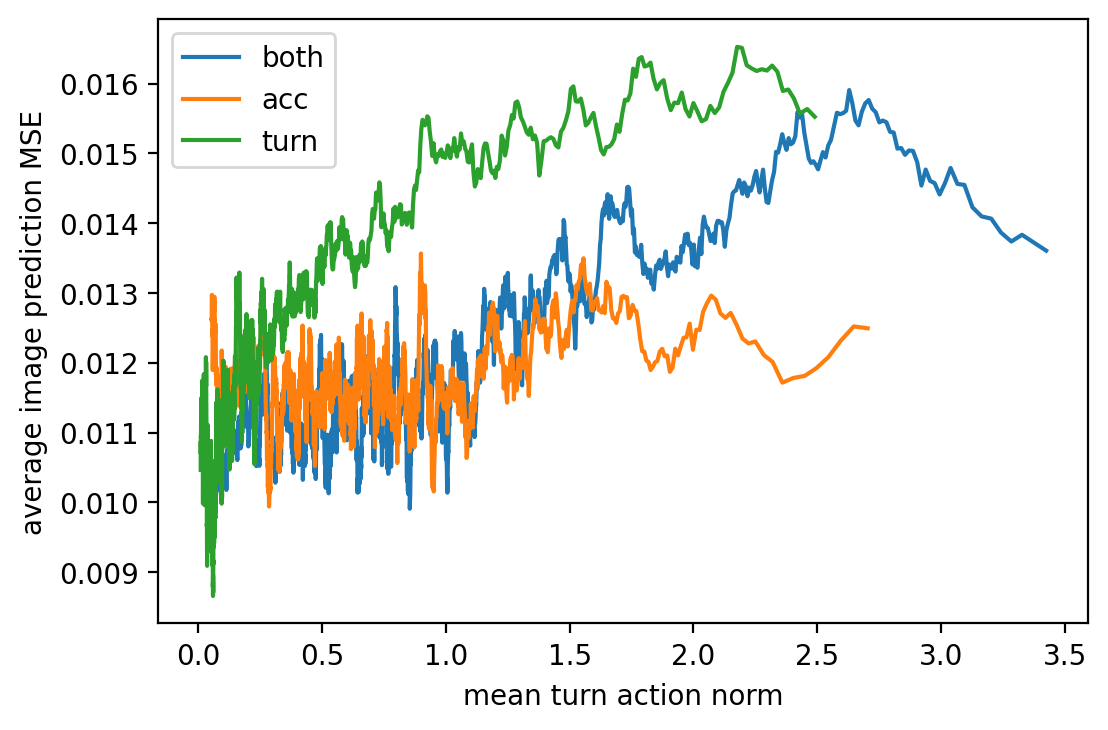

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def get_df(l2, metric):
    t_l2s = torch.cat(l2)
    t_m = torch.cat(metric)
    idx = torch.argsort(t_m)
    
    m_norms = t_m[idx].cpu().numpy()
    t_l2s = t_l2s[idx].cpu().numpy()
    
    x = np.asarray([m_norms, t_l2s])
    
    return pd.DataFrame(x.T, columns=['a', 'v'])

df_a = get_df(l2s, a_norms)
df_acc = get_df(l2s, acc_norms)
df_turn = get_df(l2s, turn_norms)

plt.figure(dpi=200)
plt.plot(df_a.rolling(100).mean()['a'], df_a.rolling(40).mean()['v'], label='both')
plt.plot(df_acc.rolling(100).mean()['a'], df_acc.rolling(40).mean()['v'], label='acc')
plt.plot(df_turn.rolling(100).mean()['a'], df_turn.rolling(40).mean()['v'], label='turn')
plt.legend()
plt.xlabel('mean turn action norm')
plt.ylabel('average image prediction MSE')

In [13]:
import numpy as np

<Figure size 1200x800 with 0 Axes>

In [22]:
from matplotlib import pyplot as plt

mean_p = [np.mean(k) for k in y_p[1:]]
mean_u = [np.mean(k) for k in y_u[1:]]

In [24]:
print(mean_p)
print(mean_u)

[0.1852752535417676, 0.23218819595873355, 0.3209828170388937, 0.435350908190012, 0.5904359319806098, 0.7722653289139271, 0.9822925189137459, 1.2250089594721794, 1.4954489967226983, 1.745610262155533, 1.995418193936348, 2.2687726998329163, 2.525949056148529, 2.7475041645765303, 3.0141749250888825, 3.2134900349378586, 3.48405134499073, 3.7225751852989197, 3.9651911532878876, 4.120040116310119, 4.35591276884079, 4.485035560131073, 4.762636884450912, 4.87387644648552, 5.137632603645325, 5.319494273662567, 5.466681920289993, 5.7030235862731935, 5.829174211025238, 6.062162439823151, 6.198277747631073, 6.371425795555115, 6.506977133750915, 6.672100327014923, 6.794329123497009, 6.937133727073669, 7.096074993610382, 7.193137900829315, 7.2409054064750675, 7.387834513187409, 7.472349154949188, 7.594398543834687, 7.802717697620392, 7.875415706634522, 7.941795725822448, 8.06032729625702, 8.178433976173402, 8.239113075733185, 8.435060477256775, 8.505231311321259, 8.6256360912323, 8.651876301765443, 

In [21]:
plt.plot(x, mean_p, label='policy')
plt.plot(x, mean_u, label='uncertainty')
plt.legend()

In [20]:
x

range(1, 100)

In [26]:
plt.figure(dpi=200)
plt.show()

<Figure size 1200x800 with 0 Axes>

In [28]:
x = range(1, 100)
mean_p = [0.1852752535417676, 0.23218819595873355, 0.3209828170388937, 0.435350908190012, 0.5904359319806098, 0.7722653289139271, 0.9822925189137459, 1.2250089594721794, 1.4954489967226983, 1.745610262155533, 1.995418193936348, 2.2687726998329163, 2.525949056148529, 2.7475041645765303, 3.0141749250888825, 3.2134900349378586, 3.48405134499073, 3.7225751852989197, 3.9651911532878876, 4.120040116310119, 4.35591276884079, 4.485035560131073, 4.762636884450912, 4.87387644648552, 5.137632603645325, 5.319494273662567, 5.466681920289993, 5.7030235862731935, 5.829174211025238, 6.062162439823151, 6.198277747631073, 6.371425795555115, 6.506977133750915, 6.672100327014923, 6.794329123497009, 6.937133727073669, 7.096074993610382, 7.193137900829315, 7.2409054064750675, 7.387834513187409, 7.472349154949188, 7.594398543834687, 7.802717697620392, 7.875415706634522, 7.941795725822448, 8.06032729625702, 8.178433976173402, 8.239113075733185, 8.435060477256775, 8.505231311321259, 8.6256360912323, 8.651876301765443, 8.790512795448302, 8.892402956485748, 8.936862268447875, 9.08149095773697, 9.051609621047973, 9.226848640441894, 9.246889872550964, 9.328287262916565, 9.43508026599884, 9.499097228050232, 9.554871358871459, 9.687163805961609, 9.720104446411133, 9.825264048576354, 9.896388297080994, 9.866869440078736, 9.97348521232605, 10.064325799942017, 10.145460286140441, 10.136419258117677, 10.262071976661682, 10.244177632331848, 10.320735588073731, 10.344638795852662, 10.412386193275452, 10.457670488357543, 10.447334871292114, 10.59123233795166, 10.603608736991882, 10.724405899047852, 10.784566164016724, 10.763532514572143, 10.878496727943421, 10.918817200660705, 10.9222220993042, 11.0537824010849, 10.97773145198822, 11.093651294708252, 11.131303029060364, 11.1593150806427, 11.18780056476593, 11.267614760398864, 11.316126384735107, 11.324614195823669, 11.426655774116517, 11.43703848361969, 11.458305478096008]
mean_u = [0.31497945030219854, 0.8725676212832332, 2.205238359197974, 4.117892189323902, 6.893258612751961, 10.152441000938415, 14.039854633808137, 18.567240579128267, 23.693099019527434, 28.470583317279814, 33.18546704292297, 38.40456632137298, 43.297873668670654, 47.59346370697021, 52.651751770973206, 56.50945234298706, 61.71309357643128, 66.240500125885, 70.97630676269532, 73.87066822052002, 78.34544416427612, 80.83112457275391, 86.10351825714112, 88.19199562072754, 93.30373313903809, 96.6783532333374, 99.49767524719238, 104.03883876800538, 106.40876567840576, 110.8569552230835, 113.4743200302124, 116.71599807739258, 119.37134735107422, 122.49461101531982, 124.89053951263428, 127.58816108703613, 130.68466510772706, 132.46955211639406, 133.28304473876952, 136.13114372253418, 137.72549774169923, 140.00333278656007, 144.0729151916504, 145.42476978302003, 146.69451515197753, 148.99800621032716, 151.27196655273437, 152.36929107666015, 156.10650733947753, 157.4373913574219, 159.75129203796388, 160.16500507354738, 162.87899467468262, 164.83070121765138, 165.6739303588867, 168.47012298583985, 167.8116478729248, 171.2594457244873, 171.57927703857422, 173.12399185180664, 175.19062210083007, 176.41857856750488, 177.42978088378905, 180.03025680541992, 180.63127044677734, 182.65695762634277, 183.9603584289551, 183.33080978393554, 185.4173419189453, 187.18275451660156, 188.79739540100098, 188.54908493041992, 190.9929768371582, 190.56277099609375, 192.09948471069336, 192.49369178771974, 193.7945358276367, 194.6376416015625, 194.4276560974121, 197.23802383422853, 197.43001174926758, 199.81230056762695, 200.9726993560791, 200.45054000854492, 202.7238800048828, 203.47002334594725, 203.57749771118165, 206.15452018737793, 204.55001823425292, 206.82851264953612, 207.5664461517334, 208.0366926574707, 208.6061865234375, 210.1834275817871, 211.07351119995118, 211.24366767883302, 213.25468955993654, 213.53707946777342, 213.82301818847657]

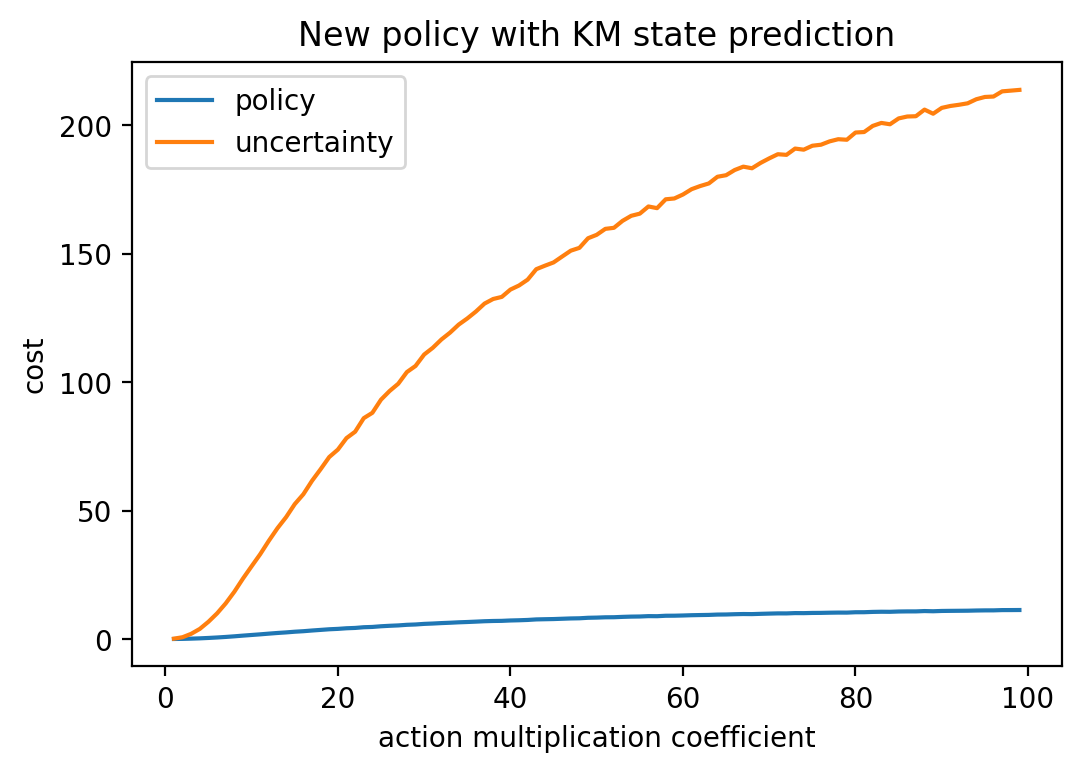

In [31]:
plt.figure(dpi=200)
plt.plot(x, mean_p, label='policy')
plt.plot(x, mean_u, label='uncertainty')
plt.xlabel('action multiplication coefficient')
plt.ylabel('cost')
plt.title('New policy with KM state prediction')
plt.legend()